In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score
from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns


In [37]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot



In [38]:

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [39]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [40]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [41]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [42]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [43]:
import random

static_1 = np.where(trainy == 3)[0]
static_2 = np.where(trainy == 4)[0]
static_3 = np.where(trainy == 5)[0]
static = np.concatenate([static_1, static_2, static_3])
static_list = static.tolist()

# Shuffle dynamic data index
r = random.random()
random.shuffle(static_list, lambda: r)

static = np.array(static)

trainX = X_train_all[static]
trainy = y_train_all[static]

<ipython-input-43-9dd469a3f9cb>:11: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(static_list, lambda: r)


In [44]:
static_1 = np.where(testy == 3)[0]
static_2 = np.where(testy == 4)[0]
static_3 = np.where(testy == 5)[0]
static = np.concatenate([static_1, static_2, static_3])
static_list = static.tolist()

r = random.random()
random.shuffle(static_list, lambda: r)

static = np.array(static_list)

testX = X_test_all[static]
testy = y_test_all[static]

<ipython-input-44-f391b7cb3b7b>:8: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(static_list, lambda: r)


In [45]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  3 491]
 [  4 532]
 [  5 537]]


In [46]:
trainy = trainy - 3
testy = testy - 3
trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [47]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (4067, 128, 9)
Y train shape:  (4067, 1)
Y train One hot shape:  (4067, 3)
X test shape:  (1560, 128, 9)
Y test shape:  (1560, 1)
Y test One hot shape:  (1560, 3)


In [48]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [49]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

# CNN1 - LSTM1

In [ ]:

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))


model.add(LSTM(100))
model.add(Dropout(0.5))

model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 dropout_4 (Dropout)         (None, 126, 64)           0         
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 63, 64)            0         
 g1D)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 100)               66000     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                      

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 14s 40ms/step - loss: 0.4899 - accuracy: 0.8217 - val_loss: 0.3040 - val_accuracy: 0.8665
Epoch 2/10
32/32 [==============================] - 1s 16ms/step - loss: 0.2485 - accuracy: 0.9012 - val_loss: 0.2165 - val_accuracy: 0.9214
Epoch 3/10
32/32 [==============================] - 0s 14ms/step - loss: 0.2190 - accuracy: 0.9149 - val_loss: 0.2079 - val_accuracy: 0.9271
Epoch 4/10
32/32 [==============================] - 0s 13ms/step - loss: 0.2534 - accuracy: 0.9066 - val_loss: 0.2208 - val_accuracy: 0.9238
Epoch 5/10
32/32 [==============================] - 0s 13ms/step - loss: 0.2219 - accuracy: 0.9144 - val_loss: 0.4344 - val_accuracy: 0.8837
Epoch 6/10
32/32 [==============================] - 1s 17ms/step - loss: 0.2614 - accuracy: 0.9014 - val_loss: 0.2405 - val_accuracy: 0.9091
Epoch 7/10
32/32 [==============================] - 0s 13ms/step - loss: 0.2009 - accuracy: 0.9120 - val_loss: 0.2090 - val_accuracy: 0.9017
Epoch 8/10
3

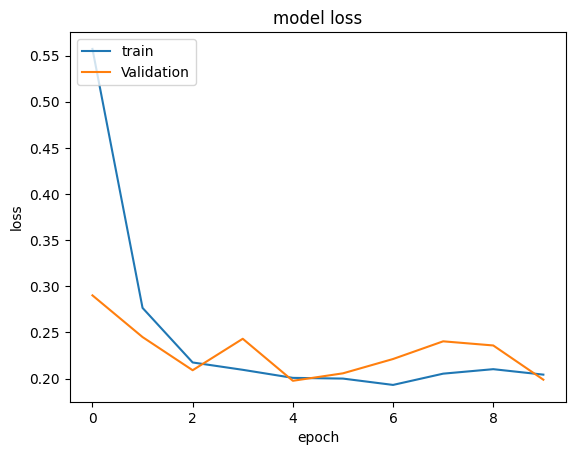

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

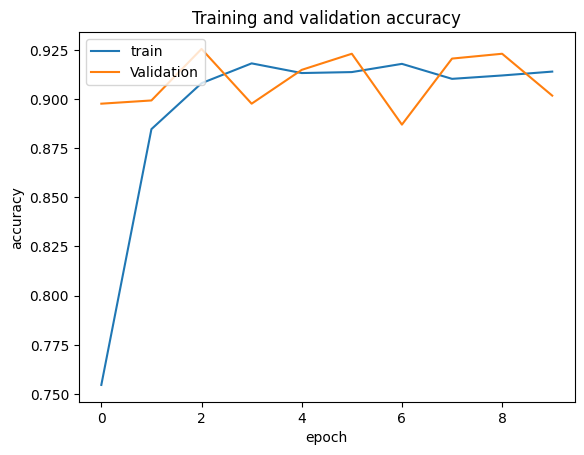

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 3ms/step
[[358 133   0]
 [ 55 477   0]
 [  0  27 510]]
0.8621794871794872
0.8629467510371226
              precision    recall  f1-score   support

           0       0.87      0.73      0.79       491
           1       0.75      0.90      0.82       532
           2       1.00      0.95      0.97       537

    accuracy                           0.86      1560
   macro avg       0.87      0.86      0.86      1560
weighted avg       0.87      0.86      0.86      1560



<Axes: >

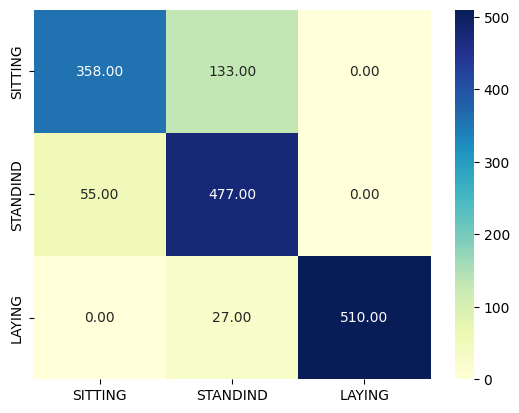

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# Layer 3

# CNN 1 - LSTM2



In [ ]:

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100))

model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_29 (Conv1D)          (None, 126, 64)           1792      
                                                                 
 dropout_42 (Dropout)        (None, 126, 64)           0         
                                                                 
 max_pooling1d_22 (MaxPooli  (None, 63, 64)            0         
 ng1D)                                                           
                                                                 
 lstm_31 (LSTM)              (None, 63, 100)           66000     
                                                                 
 lstm_32 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_43 (Dropout)        (None, 100)               0         
                                                     

In [ ]:

# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 8s 42ms/step - loss: 0.5384 - accuracy: 0.7482 - val_loss: 0.3659 - val_accuracy: 0.7969
Epoch 2/10
32/32 [==============================] - 0s 13ms/step - loss: 0.2390 - accuracy: 0.9012 - val_loss: 0.2180 - val_accuracy: 0.9197
Epoch 3/10
32/32 [==============================] - 1s 18ms/step - loss: 0.2094 - accuracy: 0.9139 - val_loss: 0.3331 - val_accuracy: 0.7854
Epoch 4/10
32/32 [==============================] - 1s 16ms/step - loss: 0.1952 - accuracy: 0.9164 - val_loss: 0.2066 - val_accuracy: 0.9140
Epoch 5/10
32/32 [==============================] - 1s 17ms/step - loss: 0.2023 - accuracy: 0.9149 - val_loss: 0.2589 - val_accuracy: 0.8862
Epoch 6/10
32/32 [==============================] - 1s 16ms/step - loss: 0.2037 - accuracy: 0.9154 - val_loss: 0.2469 - val_accuracy: 0.8952
Epoch 7/10
32/32 [==============================] - 1s 17ms/step - loss: 0.1862 - accuracy: 0.9186 - val_loss: 0.2239 - val_accuracy: 0.9148
Epoch 8/10
32

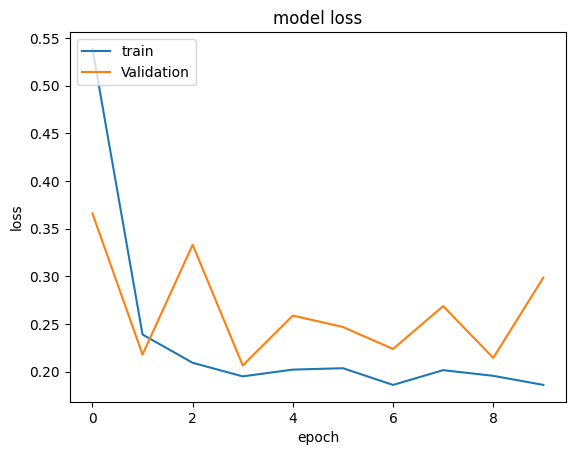

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

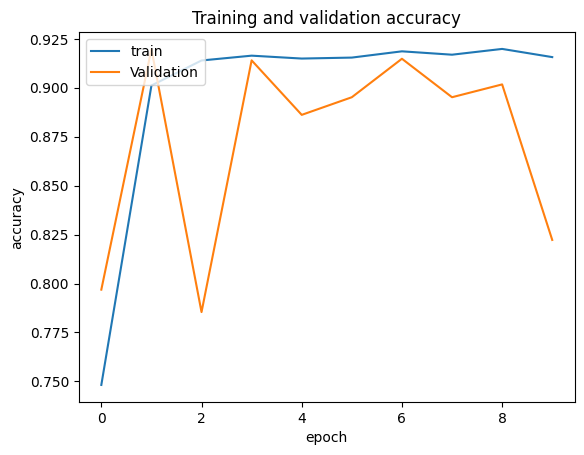

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 4ms/step
[[466  25   0]
 [218 314   0]
 [  0  27 510]]
0.8269230769230769
0.8234957866478354
              precision    recall  f1-score   support

           0       0.68      0.95      0.79       491
           1       0.86      0.59      0.70       532
           2       1.00      0.95      0.97       537

    accuracy                           0.83      1560
   macro avg       0.85      0.83      0.82      1560
weighted avg       0.85      0.83      0.82      1560



<Axes: >

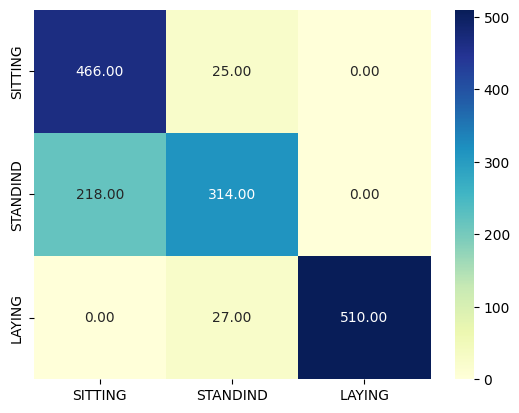

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN2 - LSTM1

In [17]:

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(100))

model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 126, 64)           1792      
                                                                 
 conv1d_1 (Conv1D)           (None, 124, 64)           12352     
                                                                 
 dropout (Dropout)           (None, 124, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 62, 64)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 100)               66000     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                        

In [18]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 20s 35ms/step - loss: 0.5086 - accuracy: 0.7866 - val_loss: 0.2715 - val_accuracy: 0.8821
Epoch 2/10
32/32 [==============================] - 0s 10ms/step - loss: 0.2692 - accuracy: 0.9026 - val_loss: 0.2171 - val_accuracy: 0.8894
Epoch 3/10
32/32 [==============================] - 0s 10ms/step - loss: 0.2618 - accuracy: 0.9063 - val_loss: 0.2767 - val_accuracy: 0.9091
Epoch 4/10
32/32 [==============================] - 0s 10ms/step - loss: 0.2314 - accuracy: 0.9041 - val_loss: 0.2093 - val_accuracy: 0.9181
Epoch 5/10
32/32 [==============================] - 0s 9ms/step - loss: 0.1998 - accuracy: 0.9157 - val_loss: 0.1918 - val_accuracy: 0.9017
Epoch 6/10
32/32 [==============================] - 0s 10ms/step - loss: 0.1978 - accuracy: 0.9107 - val_loss: 0.2067 - val_accuracy: 0.9197
Epoch 7/10
32/32 [==============================] - 0s 11ms/step - loss: 0.1949 - accuracy: 0.9174 - val_loss: 0.2020 - val_accuracy: 0.9206
Epoch 8/10
32

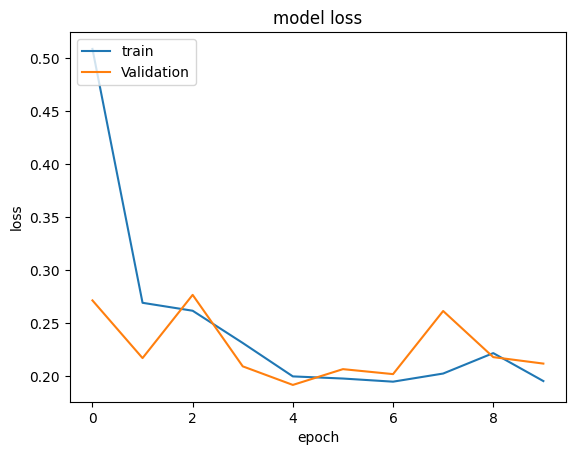

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

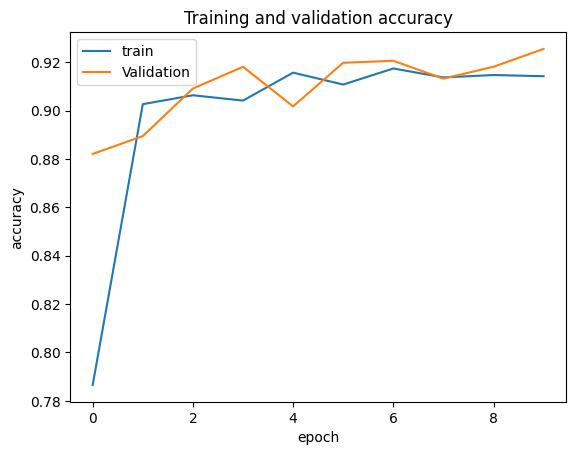

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 4ms/step
[[382 109   0]
 [ 84 448   0]
 [  0  27 510]]
0.8589743589743589
0.8604207768277367
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       491
           1       0.77      0.84      0.80       532
           2       1.00      0.95      0.97       537

    accuracy                           0.86      1560
   macro avg       0.86      0.86      0.86      1560
weighted avg       0.86      0.86      0.86      1560



<Axes: >

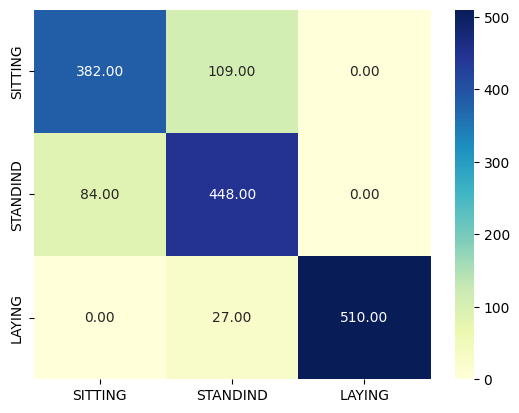

In [21]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# Layer4

# CNN1 - LSTM3

In [ ]:

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))

model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100))

model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 dropout_11 (Dropout)        (None, 126, 64)           0         
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 63, 64)            0         
 g1D)                                                            
                                                                 
 lstm_9 (LSTM)               (None, 63, 100)           66000     
                                                                 
 lstm_10 (LSTM)              (None, 63, 100)           80400     
                                                                 
 lstm_11 (LSTM)              (None, 100)               80400     
                                                      

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 14s 71ms/step - loss: 0.5265 - accuracy: 0.7846 - val_loss: 0.3549 - val_accuracy: 0.8698
Epoch 2/10
32/32 [==============================] - 1s 18ms/step - loss: 0.2672 - accuracy: 0.9012 - val_loss: 0.2166 - val_accuracy: 0.9115
Epoch 3/10
32/32 [==============================] - 1s 18ms/step - loss: 0.2149 - accuracy: 0.9115 - val_loss: 0.2016 - val_accuracy: 0.9263
Epoch 4/10
32/32 [==============================] - 1s 17ms/step - loss: 0.2055 - accuracy: 0.9142 - val_loss: 0.2018 - val_accuracy: 0.8878
Epoch 5/10
32/32 [==============================] - 1s 17ms/step - loss: 0.1919 - accuracy: 0.9223 - val_loss: 0.1940 - val_accuracy: 0.9222
Epoch 6/10
32/32 [==============================] - 1s 17ms/step - loss: 0.1998 - accuracy: 0.9198 - val_loss: 0.1946 - val_accuracy: 0.9238
Epoch 7/10
32/32 [==============================] - 1s 18ms/step - loss: 0.2028 - accuracy: 0.9098 - val_loss: 0.2024 - val_accuracy: 0.9222
Epoch 8/10
3

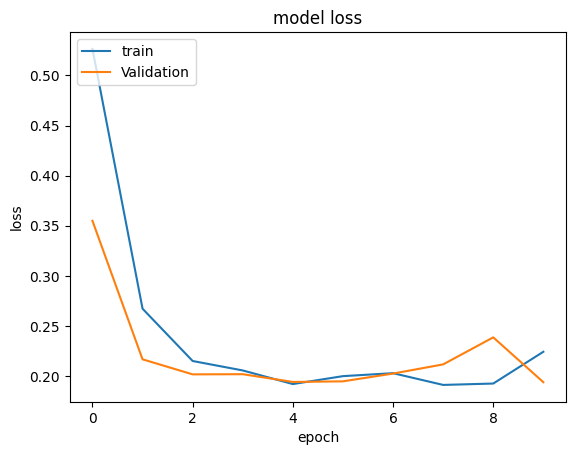

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

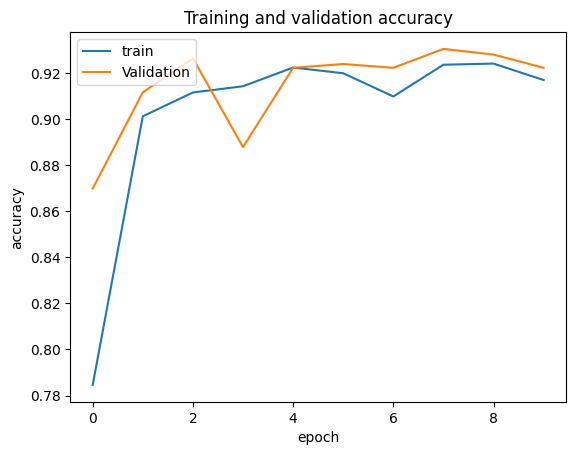

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 3s 10ms/step
[[377 114   0]
 [ 82 450   0]
 [  0  27 510]]
0.857051282051282
0.858467166382409
              precision    recall  f1-score   support

           0       0.82      0.77      0.79       491
           1       0.76      0.85      0.80       532
           2       1.00      0.95      0.97       537

    accuracy                           0.86      1560
   macro avg       0.86      0.85      0.86      1560
weighted avg       0.86      0.86      0.86      1560



<Axes: >

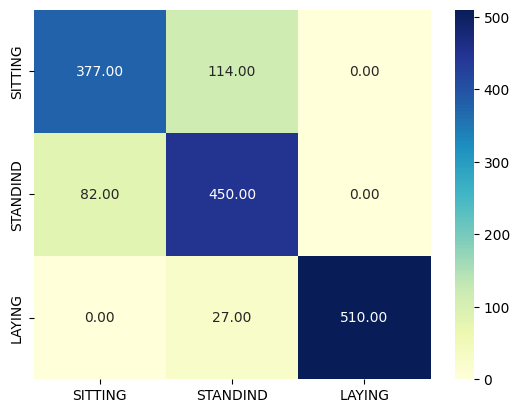

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN2 - LSTM2

In [22]:

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100))

model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 conv1d_3 (Conv1D)           (None, 124, 64)           12352     
                                                                 
 dropout_2 (Dropout)         (None, 124, 64)           0         
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 62, 64)            0         
 g1D)                                                            
                                                                 
 lstm_1 (LSTM)               (None, 62, 100)           66000     
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                      

In [23]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 6s 42ms/step - loss: 0.5065 - accuracy: 0.7866 - val_loss: 0.2843 - val_accuracy: 0.8886
Epoch 2/10
32/32 [==============================] - 0s 14ms/step - loss: 0.2433 - accuracy: 0.8972 - val_loss: 0.2248 - val_accuracy: 0.9263
Epoch 3/10
32/32 [==============================] - 1s 18ms/step - loss: 0.2093 - accuracy: 0.9098 - val_loss: 0.2077 - val_accuracy: 0.9247
Epoch 4/10
32/32 [==============================] - 1s 19ms/step - loss: 0.2011 - accuracy: 0.9169 - val_loss: 0.2280 - val_accuracy: 0.9197
Epoch 5/10
32/32 [==============================] - 1s 23ms/step - loss: 0.1945 - accuracy: 0.9171 - val_loss: 0.2902 - val_accuracy: 0.8976
Epoch 6/10
32/32 [==============================] - 1s 19ms/step - loss: 0.2046 - accuracy: 0.9137 - val_loss: 0.2078 - val_accuracy: 0.9042
Epoch 7/10
32/32 [==============================] - 1s 23ms/step - loss: 0.1926 - accuracy: 0.9157 - val_loss: 0.2846 - val_accuracy: 0.8640
Epoch 8/10
32

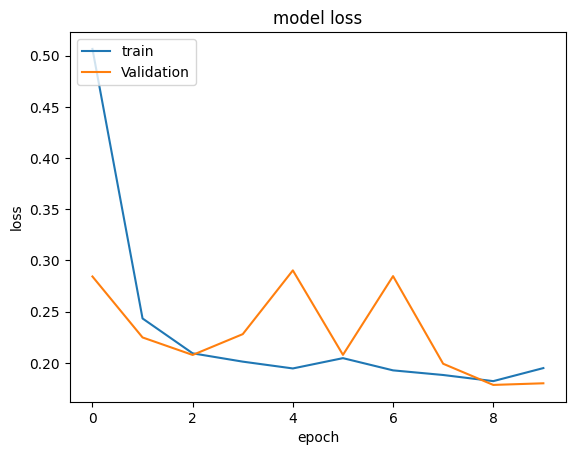

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

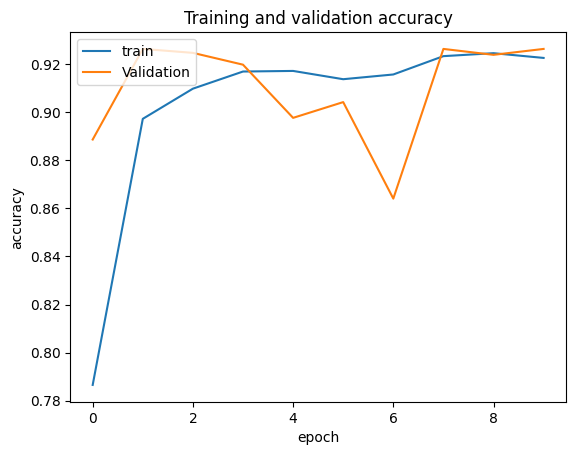

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 2s 9ms/step
[[376 109   6]
 [ 75 457   0]
 [  0  18 519]]
0.8666666666666667
0.8670105959574466
              precision    recall  f1-score   support

           0       0.83      0.77      0.80       491
           1       0.78      0.86      0.82       532
           2       0.99      0.97      0.98       537

    accuracy                           0.87      1560
   macro avg       0.87      0.86      0.86      1560
weighted avg       0.87      0.87      0.87      1560



<Axes: >

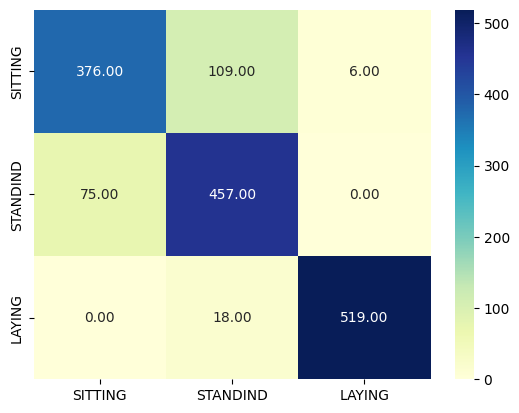

In [26]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN3 - LSTM1

In [27]:

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100))

model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 conv1d_5 (Conv1D)           (None, 124, 64)           12352     
                                                                 
 dropout_4 (Dropout)         (None, 124, 64)           0         
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 62, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 60, 64)            12352     
                                                                 
 dropout_5 (Dropout)         (None, 60, 64)            0         
                                                      

In [31]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 10s 42ms/step - loss: 0.5053 - accuracy: 0.7799 - val_loss: 0.2817 - val_accuracy: 0.8788
Epoch 2/10
32/32 [==============================] - 0s 12ms/step - loss: 0.2408 - accuracy: 0.9046 - val_loss: 0.2364 - val_accuracy: 0.9238
Epoch 3/10
32/32 [==============================] - 0s 12ms/step - loss: 0.2139 - accuracy: 0.9144 - val_loss: 0.2255 - val_accuracy: 0.9165
Epoch 4/10
32/32 [==============================] - 0s 11ms/step - loss: 0.2082 - accuracy: 0.9166 - val_loss: 0.2155 - val_accuracy: 0.9271
Epoch 5/10
32/32 [==============================] - 0s 12ms/step - loss: 0.2007 - accuracy: 0.9159 - val_loss: 0.2114 - val_accuracy: 0.9066
Epoch 6/10
32/32 [==============================] - 0s 12ms/step - loss: 0.2020 - accuracy: 0.9171 - val_loss: 0.2425 - val_accuracy: 0.9083
Epoch 7/10
32/32 [==============================] - 0s 11ms/step - loss: 0.1954 - accuracy: 0.9245 - val_loss: 0.2581 - val_accuracy: 0.8829
Epoch 8/10
3

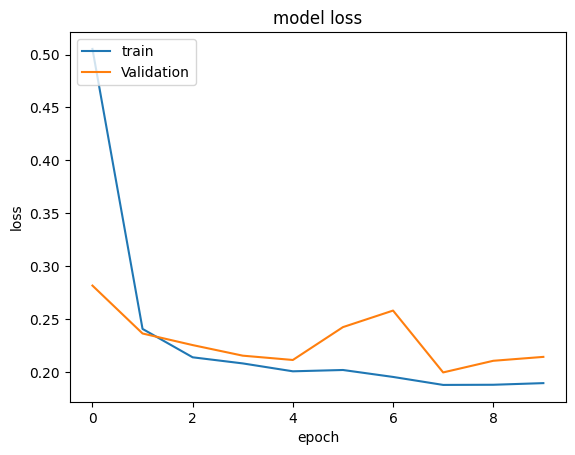

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

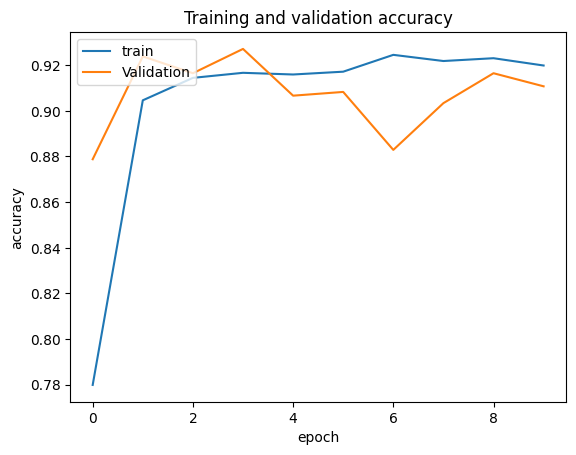

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 0s 4ms/step
[[421  70   0]
 [120 412   0]
 [  0  27 510]]
0.860897435897436
0.8620880521957559
              precision    recall  f1-score   support

           0       0.78      0.86      0.82       491
           1       0.81      0.77      0.79       532
           2       1.00      0.95      0.97       537

    accuracy                           0.86      1560
   macro avg       0.86      0.86      0.86      1560
weighted avg       0.87      0.86      0.86      1560



<Axes: >

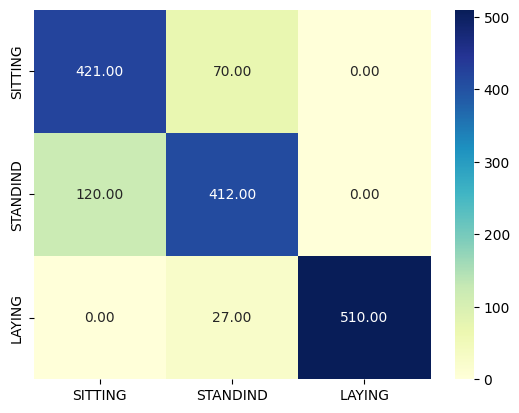

In [34]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# Layer5

# CNN

# C4 L1

In [50]:

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100))

model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 conv1d_8 (Conv1D)           (None, 124, 64)           12352     
                                                                 
 dropout_7 (Dropout)         (None, 124, 64)           0         
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 62, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_9 (Conv1D)           (None, 60, 64)            12352     
                                                                 
 conv1d_10 (Conv1D)          (None, 58, 64)            12352     
                                                      

In [51]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 8s 53ms/step - loss: 0.5106 - accuracy: 0.7615 - val_loss: 0.2595 - val_accuracy: 0.8960
Epoch 2/10
32/32 [==============================] - 0s 11ms/step - loss: 0.2391 - accuracy: 0.9093 - val_loss: 0.2579 - val_accuracy: 0.8927
Epoch 3/10
32/32 [==============================] - 0s 12ms/step - loss: 0.2184 - accuracy: 0.9083 - val_loss: 0.2610 - val_accuracy: 0.8952
Epoch 4/10
32/32 [==============================] - 0s 11ms/step - loss: 0.2020 - accuracy: 0.9194 - val_loss: 0.2350 - val_accuracy: 0.9099
Epoch 5/10
32/32 [==============================] - 0s 11ms/step - loss: 0.2000 - accuracy: 0.9112 - val_loss: 0.1899 - val_accuracy: 0.9214
Epoch 6/10
32/32 [==============================] - 0s 12ms/step - loss: 0.2014 - accuracy: 0.9189 - val_loss: 0.2393 - val_accuracy: 0.8935
Epoch 7/10
32/32 [==============================] - 0s 12ms/step - loss: 0.1823 - accuracy: 0.9189 - val_loss: 0.2541 - val_accuracy: 0.8788
Epoch 8/10
32

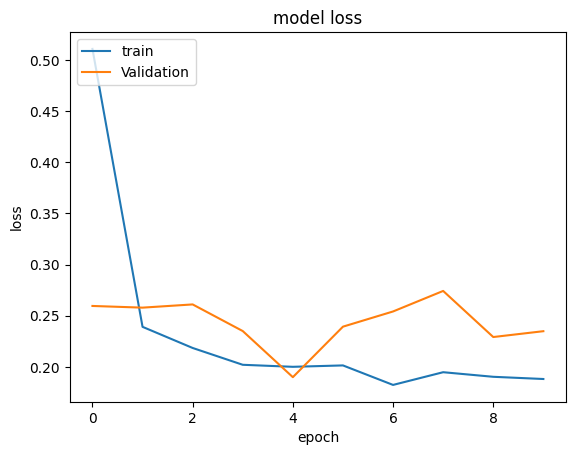

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

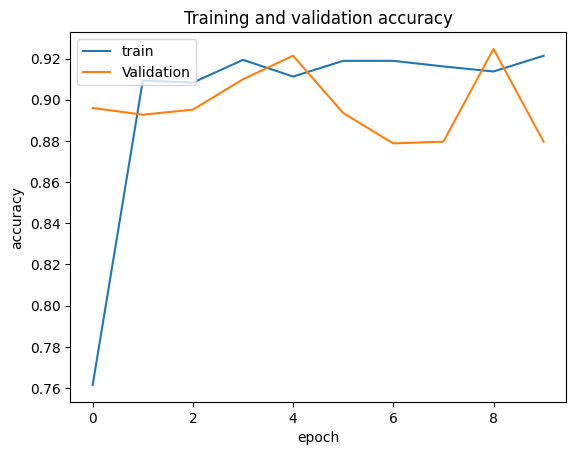

In [53]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 4ms/step
[[452  39   0]
 [147 385   0]
 [  0  27 510]]
0.8634615384615385
0.8635197786473188
              precision    recall  f1-score   support

           0       0.75      0.92      0.83       491
           1       0.85      0.72      0.78       532
           2       1.00      0.95      0.97       537

    accuracy                           0.86      1560
   macro avg       0.87      0.86      0.86      1560
weighted avg       0.87      0.86      0.86      1560



<Axes: >

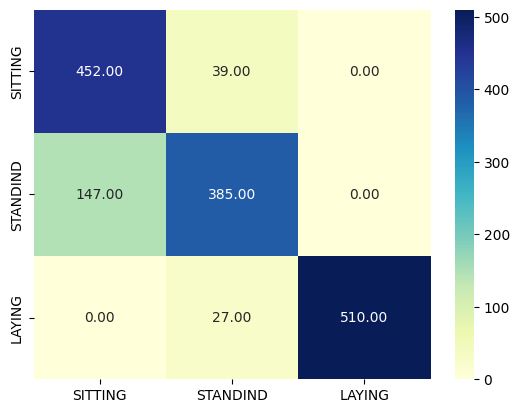

In [54]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# Timedistributed

In [ ]:
n_steps = 4
n_features = trainX.shape[2]
n_length = 32

trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
X_val = X_val.reshape((X_val.shape[0], n_steps, n_length, n_features))
print(trainX.shape,testX.shape)

(4067, 4, 32, 9) (1560, 4, 32, 9)


In [ ]:
n_timesteps, n_features, n_outputs = n_steps * n_length, trainX.shape[3], testy_one_hot.shape[1]

# CNN1 - LSTM1

In [ ]:
# Model 1
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))

model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDi  (None, None, 30, 64)      1792      
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, None, 30, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_6 (TimeDi  (None, None, 15, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_7 (TimeDi  (None, None, 960)         0         
 stributed)                                                      
                                                                 
 lstm_23 (LSTM)              (None, 100)             

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 5s 28ms/step - loss: 0.3756 - accuracy: 0.8439 - val_loss: 0.2086 - val_accuracy: 0.8960
Epoch 2/10
32/32 [==============================] - 0s 8ms/step - loss: 0.2147 - accuracy: 0.9075 - val_loss: 0.2024 - val_accuracy: 0.9238
Epoch 3/10
32/32 [==============================] - 0s 8ms/step - loss: 0.2019 - accuracy: 0.9125 - val_loss: 0.1990 - val_accuracy: 0.9271
Epoch 4/10
32/32 [==============================] - 0s 7ms/step - loss: 0.2002 - accuracy: 0.9181 - val_loss: 0.2068 - val_accuracy: 0.8976
Epoch 5/10
32/32 [==============================] - 0s 9ms/step - loss: 0.1929 - accuracy: 0.9176 - val_loss: 0.1876 - val_accuracy: 0.9279
Epoch 6/10
32/32 [==============================] - 0s 8ms/step - loss: 0.1924 - accuracy: 0.9130 - val_loss: 0.1942 - val_accuracy: 0.9255
Epoch 7/10
32/32 [==============================] - 0s 9ms/step - loss: 0.1851 - accuracy: 0.9216 - val_loss: 0.1946 - val_accuracy: 0.9075
Epoch 8/10
32/32 [=

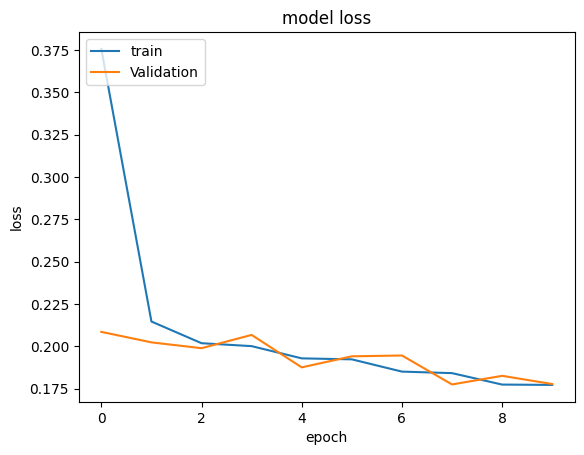

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

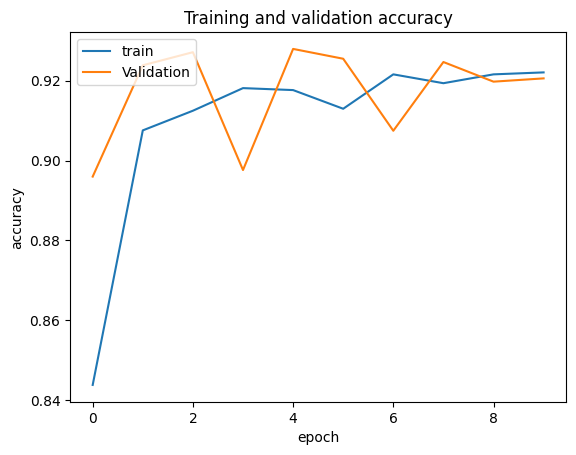

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 0s 2ms/step
[[393  98   0]
 [ 75 457   0]
 [  0   3 534]]
0.8871794871794871
0.8871925154218614
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       491
           1       0.82      0.86      0.84       532
           2       1.00      0.99      1.00       537

    accuracy                           0.89      1560
   macro avg       0.89      0.88      0.89      1560
weighted avg       0.89      0.89      0.89      1560



<Axes: >

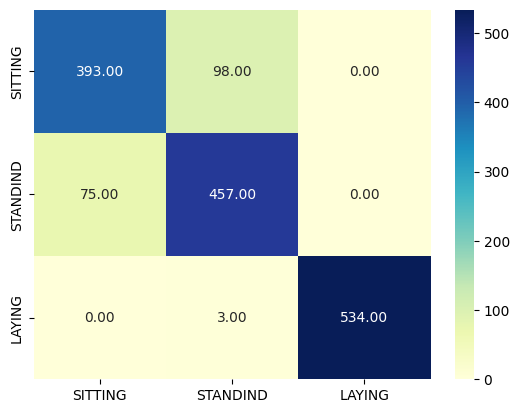

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN1 - LSTM2

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDi  (None, None, 30, 64)      1792      
 stributed)                                                      
                                                                 
 time_distributed_9 (TimeDi  (None, None, 30, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_10 (TimeD  (None, None, 15, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, None, 960)         0         
 istributed)                                                     
                                                                 
 lstm_24 (LSTM)              (None, None, 100)       

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 6s 37ms/step - loss: 0.4490 - accuracy: 0.8097 - val_loss: 0.2246 - val_accuracy: 0.8845
Epoch 2/10
32/32 [==============================] - 0s 14ms/step - loss: 0.2213 - accuracy: 0.9044 - val_loss: 0.2051 - val_accuracy: 0.8968
Epoch 3/10
32/32 [==============================] - 0s 12ms/step - loss: 0.2100 - accuracy: 0.9117 - val_loss: 0.1943 - val_accuracy: 0.9034
Epoch 4/10
32/32 [==============================] - 0s 12ms/step - loss: 0.1978 - accuracy: 0.9125 - val_loss: 0.1888 - val_accuracy: 0.9107
Epoch 5/10
32/32 [==============================] - 0s 13ms/step - loss: 0.1959 - accuracy: 0.9120 - val_loss: 0.1841 - val_accuracy: 0.9214
Epoch 6/10
32/32 [==============================] - 0s 13ms/step - loss: 0.1986 - accuracy: 0.9139 - val_loss: 0.1821 - val_accuracy: 0.9206
Epoch 7/10
32/32 [==============================] - 0s 12ms/step - loss: 0.1833 - accuracy: 0.9179 - val_loss: 0.1795 - val_accuracy: 0.9091
Epoch 8/10
32

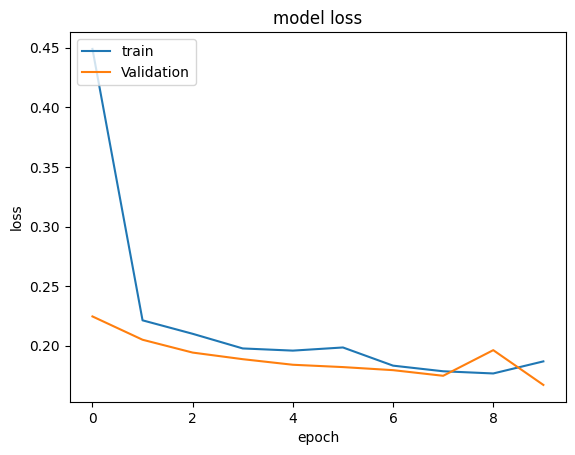

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

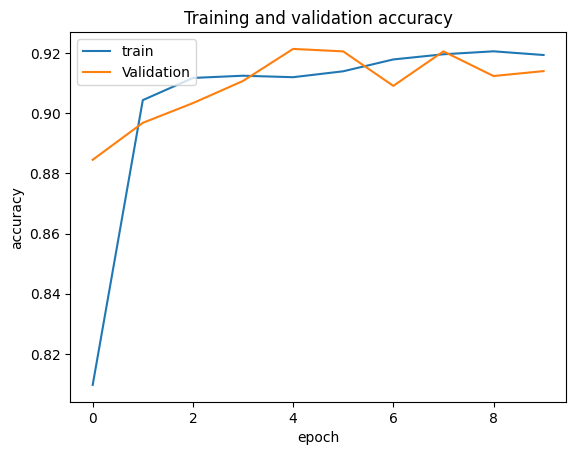

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 3ms/step
[[386 105   0]
 [ 82 450   0]
 [  0   1 536]]
0.8794871794871795
0.8793786047351476
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       491
           1       0.81      0.85      0.83       532
           2       1.00      1.00      1.00       537

    accuracy                           0.88      1560
   macro avg       0.88      0.88      0.88      1560
weighted avg       0.88      0.88      0.88      1560



<Axes: >

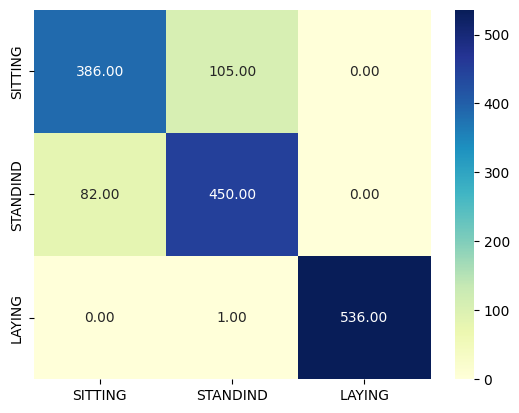

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN2- LSTM1

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))


model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_13 (TimeD  (None, None, 28, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_14 (TimeD  (None, None, 28, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_15 (TimeD  (None, None, 14, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_16 (TimeD  (None, None, 896)       

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 7s 31ms/step - loss: 0.4127 - accuracy: 0.8303 - val_loss: 0.2189 - val_accuracy: 0.8993
Epoch 2/10
32/32 [==============================] - 0s 9ms/step - loss: 0.2104 - accuracy: 0.9095 - val_loss: 0.2075 - val_accuracy: 0.9156
Epoch 3/10
32/32 [==============================] - 0s 8ms/step - loss: 0.2149 - accuracy: 0.9078 - val_loss: 0.2288 - val_accuracy: 0.8903
Epoch 4/10
32/32 [==============================] - 0s 8ms/step - loss: 0.2085 - accuracy: 0.9149 - val_loss: 0.2315 - val_accuracy: 0.9115
Epoch 5/10
32/32 [==============================] - 0s 8ms/step - loss: 0.2011 - accuracy: 0.9134 - val_loss: 0.1972 - val_accuracy: 0.9214
Epoch 6/10
32/32 [==============================] - 0s 9ms/step - loss: 0.1880 - accuracy: 0.9211 - val_loss: 0.1878 - val_accuracy: 0.9140
Epoch 7/10
32/32 [==============================] - 0s 9ms/step - loss: 0.1792 - accuracy: 0.9211 - val_loss: 0.1891 - val_accuracy: 0.9156
Epoch 8/10
32/32 [=

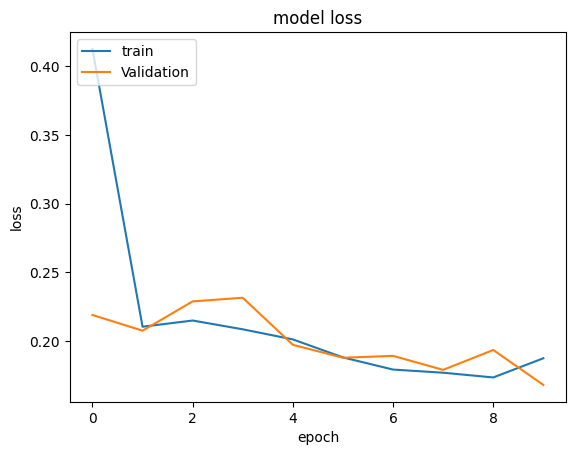

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

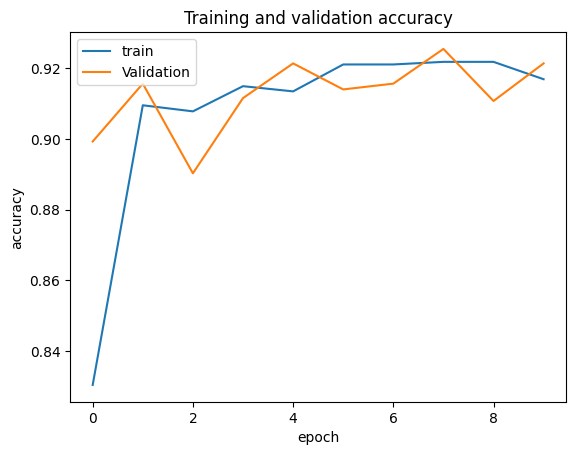

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 3ms/step
[[390 101   0]
 [ 90 442   0]
 [  0  27 510]]
0.8602564102564103
0.8617491082035287
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       491
           1       0.78      0.83      0.80       532
           2       1.00      0.95      0.97       537

    accuracy                           0.86      1560
   macro avg       0.86      0.86      0.86      1560
weighted avg       0.86      0.86      0.86      1560



<Axes: >

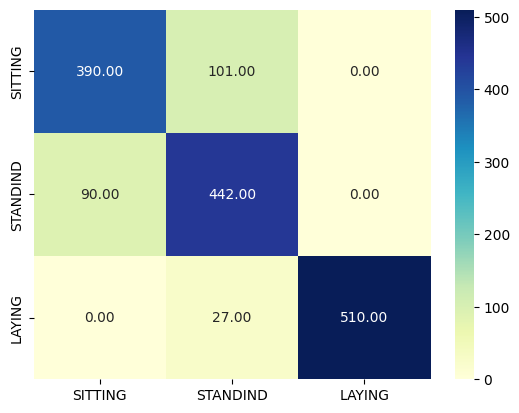

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN2 -LSTM2

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_17 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_18 (TimeD  (None, None, 28, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_19 (TimeD  (None, None, 28, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_20 (TimeD  (None, None, 14, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_21 (TimeD  (None, None, 896)       

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 9s 36ms/step - loss: 0.4415 - accuracy: 0.8279 - val_loss: 0.2053 - val_accuracy: 0.9099
Epoch 2/10
32/32 [==============================] - 0s 10ms/step - loss: 0.2204 - accuracy: 0.9098 - val_loss: 0.1944 - val_accuracy: 0.9238
Epoch 3/10
32/32 [==============================] - 0s 10ms/step - loss: 0.2172 - accuracy: 0.9078 - val_loss: 0.2081 - val_accuracy: 0.9099
Epoch 4/10
32/32 [==============================] - 0s 9ms/step - loss: 0.2018 - accuracy: 0.9152 - val_loss: 0.1876 - val_accuracy: 0.9165
Epoch 5/10
32/32 [==============================] - 0s 10ms/step - loss: 0.1934 - accuracy: 0.9117 - val_loss: 0.1937 - val_accuracy: 0.9075
Epoch 6/10
32/32 [==============================] - 0s 10ms/step - loss: 0.1860 - accuracy: 0.9176 - val_loss: 0.1867 - val_accuracy: 0.9099
Epoch 7/10
32/32 [==============================] - 0s 9ms/step - loss: 0.1784 - accuracy: 0.9189 - val_loss: 0.1736 - val_accuracy: 0.9255
Epoch 8/10
32/3

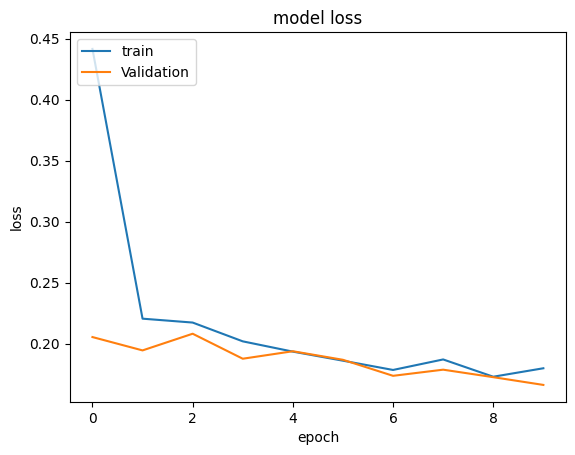

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

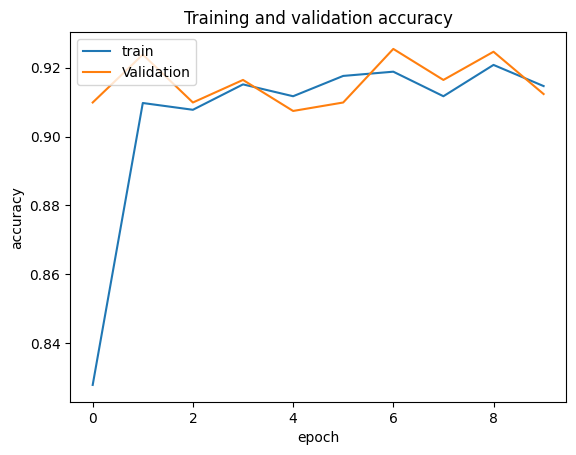

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 3ms/step
[[402  89   0]
 [101 431   0]
 [  0  27 510]]
0.860897435897436
0.8623763364156689
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       491
           1       0.79      0.81      0.80       532
           2       1.00      0.95      0.97       537

    accuracy                           0.86      1560
   macro avg       0.86      0.86      0.86      1560
weighted avg       0.86      0.86      0.86      1560



<Axes: >

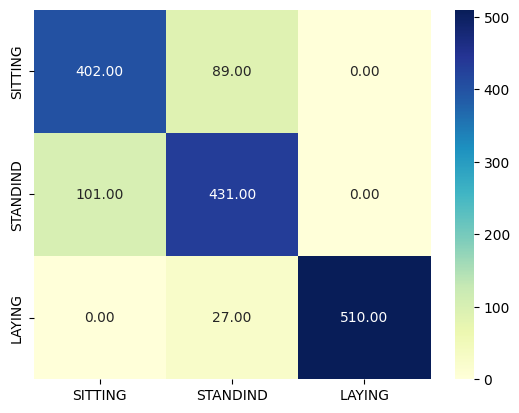

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')